In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from bayes_utils import simulation, visualize_BN

### Variable simulation

Let us take 4 binary variables $v_0, v_1, v_2$ and $v_3$ that can take values from {0,1} in such a way that we know their dependencies.

We make $v_1$ and $v_2$ dependent on $v_0$ and leave $v_3$ out as an independent one.

#### Expected structure = ((), (0,), (0, 1), ())

Meaning of this: if $v_i$ is in the $j^{th}$ tuple, it indicates that $v_j$ is dependent on $v_i$.

To see how well the structure can be learnt from the data we run a random experiment.

We simulate the data 100 times (a randomness is introduced in the data) to learn a structure from each and as we already know the expected structure of the Bayes Net, we can check how many times the learned net is exactly same.

In [3]:
dep = {1:(0,), 0:(), 2:(0,1), 3:()}

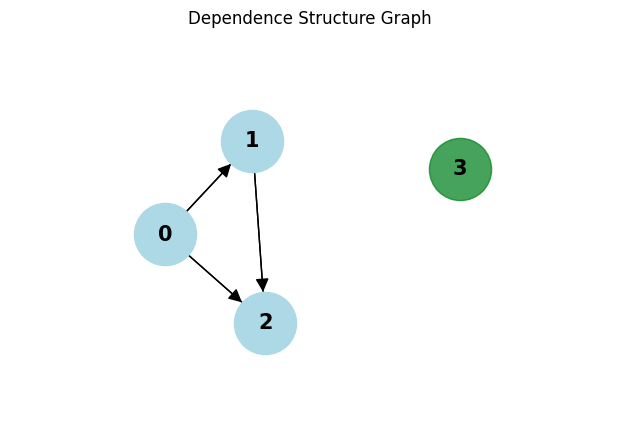

In [4]:
## Visualization of the dependence structure/Bayesian Network

visualize_BN(dependency_dict = dep)

In [5]:
data_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
reps = 100 # number of simulations per data size
accuracy = np.zeros((len(data_sizes), reps))
for d in tqdm(data_sizes):
    for i in range(reps):
        accuracy[data_sizes.index(d), i] = simulation(data_size = d, dependency_dict = dep)

100%|██████████| 10/10 [07:50<00:00, 47.03s/it]


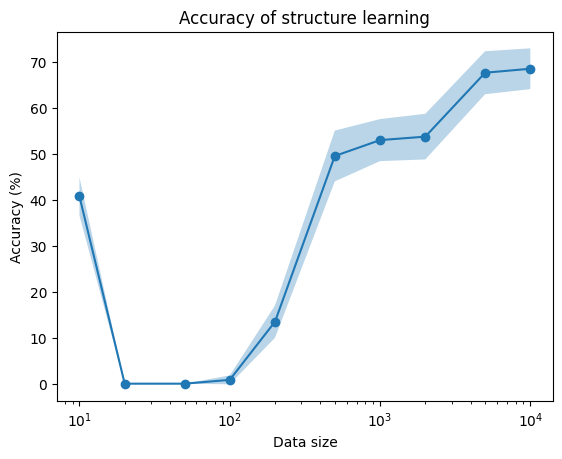

In [6]:
plt.plot(data_sizes, np.mean(accuracy, axis=1), marker = 'o')
plt.fill_between(data_sizes, np.mean(accuracy, axis=1) - np.std(accuracy, axis=1), np.mean(accuracy, axis=1) + np.std(accuracy, axis=1), alpha = 0.3)
plt.xscale('log')
plt.xlabel('Data size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of structure learning')
plt.show()

 The experiment shows that the accuracy of learning increases with the increase in number of data points.